In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from dateutil import parser as timeparser

In [3]:
data = pd.read_csv('./data-cleaned.csv', sep="\t")

/Users/asross/.pyenv/versions/3.5.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (64,65,73,75,78,79,82,90,91,105,139,140,172,182,210,212,240,284,294,297,302,308,310,312,314,322,335,337,343,381,383,385,390,408,409,410,411,413,415,430,431,434,437,451,468,469,475,476,477,480,481,482,498,509,516,522,530,535,537,553,554) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
for name in data['NAME'].unique():
  if 'ENBRIDGE' in name:
    print(name)

ENBRIDGE PIPELINES (OZARK) L.L.C.
ENBRIDGE STORAGE (CUSHING) L.L.C.
ENBRIDGE ENERGY, LIMITED PARTNERSHIP
ENBRIDGE PIPELINES (SOUTHERN LIGHTS) L.L.C.
ENBRIDGE PIPELINES (EAST TEXAS) L.P.
ENBRIDGE PIPELINES (TOLEDO) INC
ENBRIDGE ENERGY MARKETING LLC
ENBRIDGE PIPELINES (NORTH DAKOTA) LLC
ENBRIDGE STORAGE (PATOKA) L.L.C.


In [198]:
data['DATETIME'] = [timeparser.parse(d) for d in data['LOCAL_DATETIME']]
data['IS_OIL_SPILL'] = (data.UNINTENTIONAL_RELEASE_BBLS > 0.1).values & (data.COMMODITY_RELEASED_TYPE == 'CRUDE OIL')
data['IS_ENBRIDGE'] = ['ENBRIDGE' in name for name in data['NAME']]

In [199]:
data['IS_ENBRIDGE'].values.sum()

116

In [203]:
# select ROW spills by lat/lng
data['IS_ENBR_ROW'] = [
  isen and 2*lat+lng > -1 and lat > 45 and lng < -90
  for isen, lat, lng in zip(data['IS_ENBRIDGE'], data['LOCATION_LATITUDE'], data['LOCATION_LONGITUDE'])]

data['IS_LINE_67'] = ['LINE 67' in str(narr) for narr in data.NARRATIVE.values]

In [88]:
print('From 2010 to 2015 (reported in DSEIS):')
print('# enbridge incidents:', 86+6+5+1)

n_enbridge_spills = len(data.query('IS_ENBRIDGE & IS_OIL_SPILL'))
n_enbr_row_spills = len(data.query('IS_ENBR_ROW & IS_OIL_SPILL'))

print('\nFrom 2010 to Feb. 2017:')
print('# enbridge spills:', n_enbridge_spills)
print('# enbr ROW spills:', n_enbr_row_spills)
print('% spills over ROW: {:.1%}'.format(n_enbr_row_spills / n_enbridge_spills))

enbridge_total_miles_of_pipeline = 17511 # http://www.enbridge.com/about-us/our-work/transportation-and-transmission/liquids-pipelines
enbr_row_total_miles_of_pipeline = 7*327 # DSEIS 5-37

print('\nexpected % spills: {:.1%}'.format(enbr_row_total_miles_of_pipeline / enbridge_total_miles_of_pipeline))

From 2010 to 2015 (reported in DSEIS):
# enbridge incidents: 98

From 2010 to Feb. 2017:
# enbridge spills: 106
# enbr ROW spills: 37
% spills over ROW: 34.9%

expected % spills: 13.1%


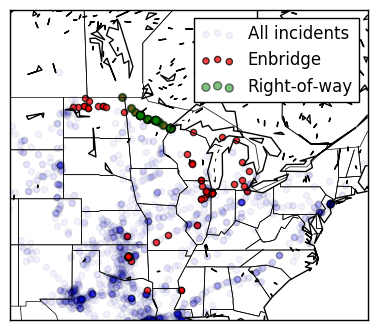

In [204]:
latlngs_all = data[['LOCATION_LATITUDE', 'LOCATION_LONGITUDE']].values
latlngs_row = data[data['IS_ENBR_ROW']][['LOCATION_LATITUDE', 'LOCATION_LONGITUDE']].values
latlngs_enb = data[data['IS_ENBRIDGE']][['LOCATION_LATITUDE', 'LOCATION_LONGITUDE']].values

bmap = Basemap(projection='merc', lat_0=40, lon_0=-100,
     area_thresh = 0.2,
    llcrnrlon=-110, llcrnrlat=30,
    urcrnrlon=-70, urcrnrlat=55)
bmap.drawcountries()
bmap.drawstates()
bmap.drawcoastlines()
 
bmap.scatter(*bmap(*reversed(latlngs_all.T)), label='All incidents',       alpha=0.05)
bmap.scatter(*bmap(*reversed(latlngs_enb.T)), label='Enbridge', c='red',   alpha=0.75)
bmap.scatter(*bmap(*reversed(latlngs_row.T)), label='Right-of-way', c='green', alpha=0.5, s=33)
plt.legend(loc='upper right')
plt.show()

In [202]:
data[data['IS_ENBR_ROW']].COMMODITY_RELEASED_TYPE.unique()

array(['CRUDE OIL'], dtype=object)

In [55]:
print(data[data['IS_LINE_67']][['REPORT_NUMBER', 'SEGMENT_NAME', 'NARRATIVE']].values)

[[20110440 'SUMP REINJECTION LINE'
  'ON NOVEMBER 8, AT APPROXIMATELY 10:10 AM LOCAL TIME,  CLEARBROOK TERMINAL STAFF DISCOVERED OIL NEAR THE SUMP RE-INJECTION WHISTLE FOR LINE 67.  THE CONTROL CENTER WAS IMMEDIATELY NOTIFIED AND LINE 67 WAS SHUTDOWN.  APPROXIMATELY 10 BARRELS OF OIL HAD LEAKED FROM THE 2" BRAIDED STEEL FLEXIBLE HOSE. THE FLEX HOSE WAS REPLACED AND THE LINE WAS STARTED LATER THE SAME DAY.     FURTHER VISUAL EXAMINATION OF THE FLEX HOSE, AFTER REMOVAL OF THE WIRE BRAID, REVEALED A CRACK TRANSVERSE TO THE AXIS OF THE HOSE.  INITIAL THIRD PARTY ANALYSIS INDICATES THE FAILURE MECHANISM WAS LIKELY DUE TO HIGH-STRESS BENDING FATIGUE.  AN INTERNAL INVESTIGATION SUPPORTED THIS FINDING.    CLEANUP OF THE SITE IS COMPLETE AND THE 36 CUBIC YARDS OF CONTAMINATED SOIL WAS DISPOSED OF AT AN APPROVED SITE.']
 [20100230 'LINE 67'
  'AT APPROXIMATELY 12:40 PM ON SEPTEMBER 23RD DEER RIVER PERSONNEL NOTICED OIL ON THE GROUND NEAR LINE 67 STATION DISCHARGE VALVE (DR-67-SDV-1). THE SOURCE 

In [60]:
data[data['IS_ENBR_ROW']].SEGMENT_NAME

114                             LINE 2 UNIT 2
365                          TANK 56 MANIFOLD
415                               TANK 1 LINE
498                          LINE 2 MP1005.31
625                                222-V-SV15
650                           CROSSOVER VALVE
655                                   6-OV-6C
768                       MANIFOLD DRAIN LINE
816                                  2-CSV-22
841                           FIELD BOOSTER 3
873                                    LINE 4
892                    LINE 6 BOOSTER PUMP 62
909                           VALVE 221-V-314
952                       MANIFOLD 225 PIPING
1073              FB25/26 - SUPERIOR TERMINAL
1078                            TANK 64 MIXER
1208                       LINE 3 UNIT 1 SEAL
1342                            LINE 4 UNIT 1
1419                            LINE 6 UNIT 4
1525                 LINE 4 SENDING TRAP DOOR
1616              LINE 1 PRESSURE TRANSMITTER
1625                    LINE 2 VIK

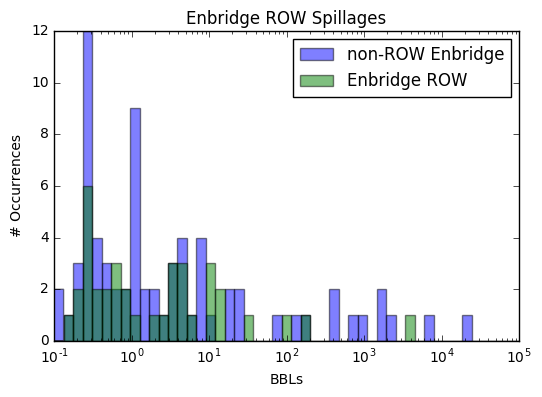

In [196]:
plt.title('Enbridge ROW Spillages')
plt.ylabel('# Occurrences')
plt.xlabel('BBLs')
plt.hist(data[~data.IS_ENBR_ROW.values & data.IS_ENBRIDGE.values]['UNINTENTIONAL_RELEASE_BBLS'],  bins=np.logspace(-1, 5, 50), alpha=0.5, label='non-ROW Enbridge')
plt.hist(data[data.IS_ENBR_ROW]['UNINTENTIONAL_RELEASE_BBLS'], bins=np.logspace(-1, 5, 50), alpha=0.5, label='Enbridge ROW')
plt.xscale('log')
plt.legend()
plt.show()

In [138]:
df1 = data[data.IS_ENBR_ROW]
df2 = df1[df1.UNINTENTIONAL_RELEASE_BBLS > 1000]
with pd.option_context('display.max_rows', None):
  display(df2.T)

,2831
REPORT_RECEIVED_DATE,4/2/2010
IYEAR,2010
REPORT_NUMBER,20100021
SUPPLEMENTAL_NUMBER,17161
REPORT_TYPE,SUPPLEMENTAL FINAL
OPERATOR_ID,11169
NAME,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP"
OPERATOR_STREET_ADDRESS,"1100 LOUISIANA, SUITE 3300"
OPERATOR_CITY_NAME,HOUSTON
OPERATOR_STATE_ABBREVIATION,TX


In [281]:
df2.NARRATIVE.values[0]

'ON JANUARY 8, 2010 AT 23:38 LOCAL TIME, THE ENBRIDGE CONTROL CENTRE NOTICED A SUDDEN DROP IN PRESSURE ON LINE 2 AND IMMEDIATELY SHUT THE  PIPELINE DOWN. ENBRIDGE SUPERIOR REGION OPERATIONS AND CENTRAL REGION OPERATIONS (CANADA) WERE NOTIFIED AND DISPATCHED. UPON ARRIVAL,  COMPANY PERSONNEL DISCOVERED A LEAK ESTIMATED AT APPROXIMATELY 3,000 BARRELS CONTAINED PRIMARILY TO THE COMPANY RIGHT-OF-WAY. ADDITIONAL  COMPANY RESOURCES WERE IMMEDIATELY DISPATCHED TO CONTROL AND CLEAN-UP THE RELEASED OIL, INVESTIGATE THE CAUSE OF THE RELEASE AND TO REPAIR  THE PIPELINE FOR RETUM TO SERVICE. THE NATIONAL RESPONSE CENTER AND NORTH DAKOTA STATE INCIDENT REPORTING HOTLINES WERE CONTACTED.    THE PRELIMINARY CAUSE OF THE PIPELINE RUPTURE WAS A FAILURE IN A SECTION OF THE LONGITUDINAL SEAM OF THE PIPE. THE AFFECTED PIPE SEGMENT WAS  REMOVED DURING THE REPAIR AND HAS BEEN SENT TO A THIRD-PARTY METALLURGICAL  LAB FOR ANALYSIS. THE PIPELINE WAS REPAIRED AND WAS RESTARTED ON  JANUARY 13, 2010 AT APPROXIMAT